Questão 01: A partir de determinada imagem, será produzido, em nível de cinza:
• Escolha cenários com bordas presentes;
• Degrade a imagem com ruído “sal e pimenta”;
• Aplique as diversas máscaras de filtragem com preservação de bordas:
    o Kuwahara et al. (1976);
    o Tomita e Tsuji (1977);
    o Nagao e Matsuyama (1979);
    o Somboonkaew et al. (1999);
    o Adelmann (1999).
• E compare com algum método tradicional.

In [20]:
import random
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def add_ruido(img):

    linha, coluna = img.shape

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 255

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 0

    return img

Após a adição do ruido "Sal e Pimenta", agora podemos trabalhar com essa nova imagem, logo abaixo é apresentado e imagem original ao lado da imagem com ruido.

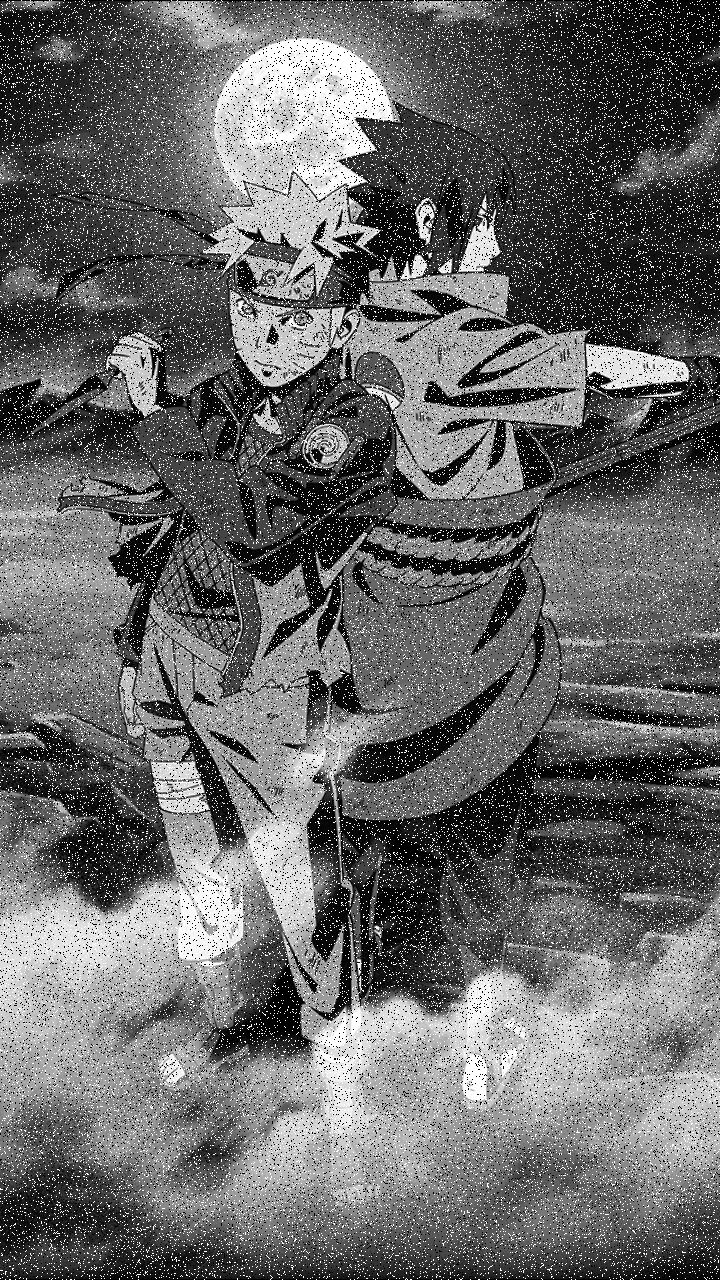

In [21]:
img = cv2.imread('naru_pretoEbranco.jpg', cv2.IMREAD_GRAYSCALE)

cv2.imwrite('salEpimenta_naru.jpg', add_ruido(img))

im1 = Image.open('naru_pretoEbranco.jpg')
im1

im2 = Image.open('salEpimenta_naru.jpg')
im2

# res1 = np.hstack((im1, im2))
# cv2.imwrite('salEpimenta_naru_lado_lado.jpg', res1)

# res2 = Image.open('salEpimenta_naru_lado_lado.jpg')
# res2

Agora podemos trabalhar com essa nova imagem, primeiro vamos aplicar a filtragem de Kuwahara.
O filtro de Kuwahara pode ser definido como um filtro não linear de suavização que não compromete a nitidez da imagem ou as posições das bordas, sendo reconhecido tradicionalmente por este segundo aspecto.

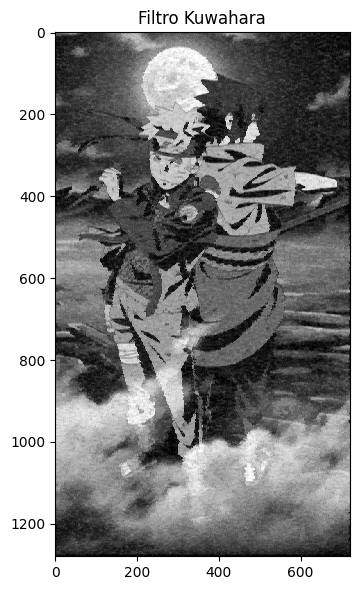

In [25]:
from scipy.signal import convolve2d
from skimage import io

def Kuwahara(img, janelaTamanho):
    image = img.astype(np.float64)
    # Verificando se o tamanho da janela está correto

    if janelaTamanho %4 != 1:
        raise Exception ("Tamanho de Janela Invalido")
    
    #Construindo Sub Janelas
    janela_1 = np.hstack((np.ones((1, (janelaTamanho-1)//2+1)), np.zeros((1, (janelaTamanho - 1)//2))))
    matriz_de_zeros = np.zeros((1, janelaTamanho))
    matriz_retangular = np.tile(janela_1, ((janelaTamanho - 1)//2+1,1))
    matriz_retangular = np.vstack((matriz_retangular, np.tile(matriz_de_zeros, ((janelaTamanho-1)//2, 1))))
    matriz_retangular = matriz_retangular/np.sum(matriz_retangular)
    # normaliza o kernel dividindo todos os seus elementos pela soma de 
    # todos os elementos,
    # o que garante que os pesos do kernel somam 1 (ou seja, a propriedade 
    # de filtro média)

    janelas = np.empty((4, janelaTamanho, janelaTamanho))
    janelas[0] = matriz_retangular  # janelas[0] representa a direção noroeste.
    janelas[1] = np.fliplr(matriz_retangular) # janelas[1] representa a direção nordeste.
    janelas[2] = np.fliplr(matriz_retangular)  # janelas[2] representa a direção sudoeste.
    janelas[3] = np.fliplr(janelas[2]) # janelas[3] representa a direção sudeste.
   
    quadradoImg = image**2

    #alocando arrays
    avgs = np.zeros([4, image.shape[0], image.shape[1]])
    alocar = avgs.copy()

    #calculando a media de variancia
    for k in range(4):
        avgs[k] = convolve2d(image, janelas[k], mode='same')

        #media dos madrados das subjanelas
        alocar[k] = convolve2d(quadradoImg, janelas[k], mode='same')

        #variancia das subjanelas
        alocar[k] = alocar[k] - avgs[k]**2

    #Escolhendo o indice com menor variancia
    indices = np.argmin(alocar, 0)

    #Construindo o filtro da imagem para cada pixel
    filtrado = np.zeros(img.shape)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            filtrado[linha, coluna] = avgs[indices[linha, coluna], linha, coluna]

   
    return filtrado.astype(np.uint8)


img_ruido = np.array(Image.open('salEpimenta_naru.jpg'))
area = 9
imgNormalKuwahara = Kuwahara(img_ruido, area)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Kuwahara")
io.imshow(imgNormalKuwahara/255)
plt.show()


Podemos agora aplicar o filtro de tomita e tsuji, nesse caso ambos usam da mesma forma uma mascara assim como o de Kuwahara, entretando aqui será aplicado cinco mascaras, ao inves de apenas 4, sendo a 5ª colocando o pixel trabalhado no centro.

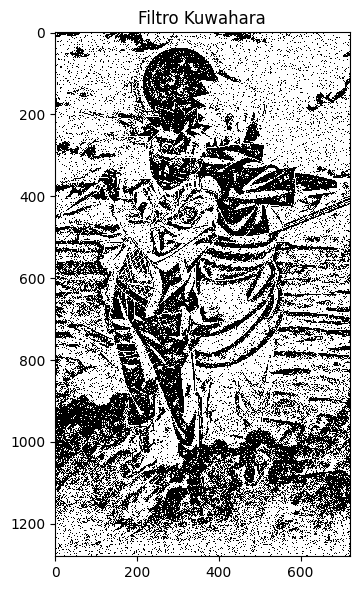

In [41]:
import numpy as np
import cv2

def tomita_tsuji_filter(img, tam_mask):
    # Define a máscara com base em seu tamanho
    mask = np.ones((tam_mask, tam_mask))
    mask[(tam_mask-1)//2, (tam_mask-1)//2] = -tam_mask**2 + 1 # criando a mascara

    # Aplica a filtragem de Tomita e Tsuji
    img_filtrada = np.abs(cv2.filter2D(img, -1, mask))
    return img_filtrada

imagem_ruido = cv2.imread('salEpimenta_naru.jpg', 0)

imgTomitaTsuji = tomita_tsuji_filter(imagem_ruido, 25)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Tomita e Tsuji")
io.imshow(imgTomitaTsuji/255)
plt.show()


Abaixo a aplicação do filtro de Nagao e Matsuyama, nesse caso a quantidade mascaras usada é de 9 ao todo, como consequencia é uma extensão do filtro de média, com a diferença de que as máscaras utilizadas no Nagao e Matsuyama são adaptadas para preservar as bordas. 

Pode se observar que por mais que não apresente a imagem com clareza, as varias bordas que estão na imagem original se apresentam minimamete.

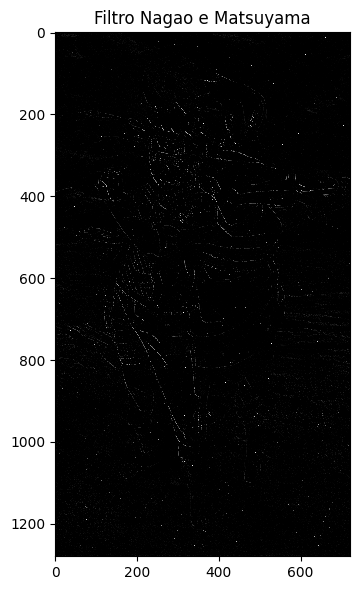

In [50]:
import numpy as np
import cv2

def nagao_matsuyama_filter(img, tam_mask):
    # Define as máscaras de Nagao e Matsuyama
    masks = []
    for i in range(tam_mask):
        for j in range(i+1, tam_mask):
            mask = np.zeros((tam_mask, tam_mask))
            mask[i, j] = 1
            mask[j, i] = -1
            masks.append(mask)
    
    # Aplica a filtragem com as máscaras de Nagao e Matsuyama
    imagens_filtradas = [np.abs(cv2.filter2D(img, -1, mask)) for mask in masks]
    imagem_filtrada = np.min(imagens_filtradas, axis=0)

    return imagem_filtrada

imagem_ruido = cv2.imread('salEpimenta_naru.jpg', 0)

imgNagaoMatsuyama = nagao_matsuyama_filter(imagem_ruido, 3)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Nagao e Matsuyama")
io.imshow(imgNagaoMatsuyama/255)
plt.show()

Em seguinte pode se observar como a imagem usando o filtro de Somboonkaew se comporta, ele é um filtro de suavização de bordas que utiliza uma combinação de 12 máscaras de suavização e uma máscara de realce para preservar as bordas em uma imagem.

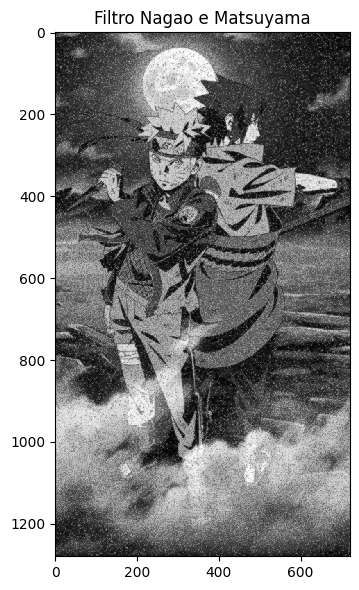

In [56]:
import numpy as np
import cv2

def somboonkaew_filter(img, tam_mask, alpha=0.2):
    # Define as máscaras de suavização e realce
    img_suaviza = np.ones((tam_mask, tam_mask), dtype=np.float32) / (tam_mask * tam_mask)
    img_realce = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=np.float32)
    
    # Aplica a filtragem com as máscaras de suavização e realce
    img_suaviza = cv2.filter2D(img, -1, img_suaviza)
    img_realce = cv2.filter2D(img, -1, img_realce)
    
    # Combina as imagens suavizada e realçada
    imagem_filtrada = (1 - alpha) * img_suaviza + alpha * img_realce
    
    return imagem_filtrada

imagem_ruido = cv2.imread('salEpimenta_naru.jpg', 0)

imgSomboonkaew = somboonkaew_filter(imagem_ruido, 5)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro de Somboonkaew")
io.imshow(imgSomboonkaew/255)
plt.show()

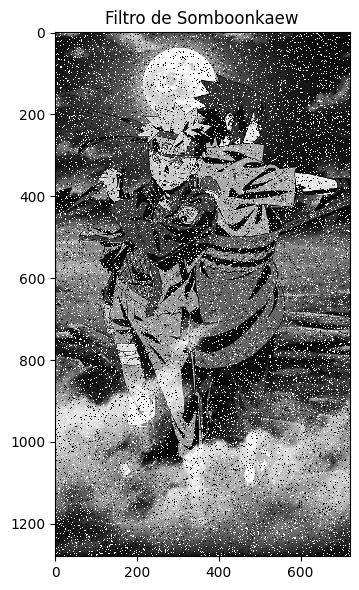

In [65]:
import numpy as np
import cv2

def adelmann_filter(img, win_size1=3, win_size2=5):
    # Define as máscaras de suavização
    smooth_mask1 = np.ones((win_size1, win_size1), dtype=np.float32) / (win_size1 * win_size1)
    smooth_mask2 = np.ones((win_size2, win_size2), dtype=np.float32) / (win_size2 * win_size2)
    
    # Aplica a filtragem com as máscaras de suavização
    smoothed_img1 = cv2.filter2D(img, -1, smooth_mask1)
    smoothed_img2 = cv2.filter2D(img, -1, smooth_mask2)
    
    # Subtrai as imagens suavizadas para obter a imagem de bordas
    edge_img = np.abs(smoothed_img1 - smoothed_img2)
    
    # Combina a imagem original com a imagem de bordas
    filtered_img = img + edge_img
    
    return filtered_img

imagem_ruido = cv2.imread('salEpimenta_naru.jpg', 0)

imgSomboonkaew = adelmann_filter(imagem_ruido, 5, 5)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro de Somboonkaew")
io.imshow(imgSomboonkaew/255)
plt.show()